# Welcome to the composite_model tutorial

The goal of this notebook is to demonstrate what composite_model is, how to use it, and the potential use cases for the model!

Formally, a CompositeModel is a PrognosticsModel that is composed of multiple PrognosticsModels. This is a tool for modeling system-of-systems. I.e., interconnected systems, where the behavior and state of one system effects the state of another system. The composite prognostics models are connected using defined connections between the output or state of one model, and the input of another model. The resulting CompositeModel behaves as a single model. 

To initialize a CompositeModel, there are two required parameters that must be passed in!
* __models__: A list of PrognosticsModels to be combined into a single model.
* __connections__: A list of tuples where the first element is the name of the output or state of one model and the second element is the name of the input of another model.

Here is some further explanation regarding __models__!

__models__ comes in the form of either a list of PrognosticsModel or a list of tuples that includes a str and a PrognosticsModel.

        models (list[PrognosticsModel] or list[tuple[str, PrognosticsModel]])

Provided in one of the two forms:

1. A list of PrognosticsModels. The name of each model will be the class name. A number will be added for duplicates
2. A list of tuples where the first element is the model name and the second element is the model

#### __KEY NOTE__

The Order of provided models will be the order that models are executed in for the composite model!

Here is some further explanation regarding __connections__!

To reiterate, __connections__ is a list of tuples where the first element is the name of the output or state of one model and the second element is the name of the input of another model.

        connections (list[tuple[str, str]], optional):

The first element of the tuple must be of the form "model_name.output_name" or "model_name.state_name".

The second element of the tuple must be of the form "model_name.input_name".

For example, if you have two modes, `Batt1` and `Batt2`, and you want to connect the output of `Batt1` to the input of `Batt2`, you would use the following connections: `("Batt1.output", "Batt2.input")`

Now, let's get started with an example

### EX 1) DC motor + Electronic Speed Controller + Propeller Load

This example creates a composite model of a DC motor with an Electronic Speed Controller and a propeller load. The three composite models are interrelated. The created composite model describes the nature of these interconnections. The resulting powertrain model is then simulated forward with time and the results are plotted.

First thing that we would want to do is import that required packages.

In [1]:
from prog_models.models import DCMotor, ESC, PropellerLoad
from prog_models import CompositeModel

This imports the DCmotor, Electronic Speed Controller (ESC), and PropellerLoad models distributed with the `prog_models` package. See <https://nasa.github.io/progpy/api_ref/prog_models/IncludedModels.html> for details on these models.

Furthermore, we import the prog_models CompositeModel Class!

First, lets define the composite models

In [2]:
m_motor = DCMotor()
m_esc = ESC()
m_load = PropellerLoad()

Next, let's combine them into a single composite model describing the behavior of a powertrain. Remember, the goal of this model to to behave as a single model!

In [3]:
m_powertrain = CompositeModel(
    (m_esc, m_load, m_motor), 
    connections = [ 
        ('DCMotor.theta', 'ESC.theta'),
        ('ESC.v_a', 'DCMotor.v_a'),
        ('ESC.v_b', 'DCMotor.v_b'),
        ('ESC.v_c', 'DCMotor.v_c'),
        ('PropellerLoad.t_l', 'DCMotor.t_l'),
        ('DCMotor.v_rot', 'PropellerLoad.v_rot')],
    outputs = {'DCMotor.v_rot', 'DCMotor.theta'})

Here, the connections are between each of the outputs from one model to another.

The key point here is that you can establish connections between models even when they are not in order. What occurs here is that when the model does have an output, then we are able to connect it back to the input of another, regardless of their current order!

Finally, let's print out the inputs, states, and outputs of the composite model to see what these values are!

In [4]:
print('Composite model of DCMotor, ESC, and Propeller load')
print('inputs: ', m_powertrain.inputs)
print('states: ', m_powertrain.states)
print('outputs: ', m_powertrain.outputs)

Composite model of DCMotor, ESC, and Propeller load
inputs:  {'ESC.v', 'ESC.duty'}
states:  {'ESC.v_b', 'DCMotor.theta', 'ESC.v_c', 'DCMotor.v_rot', 'DCMotor.i_b', 'ESC.v_a', 'DCMotor.i_a', 'PropellerLoad.t_l', 'ESC.t', 'DCMotor.i_c'}
outputs:  {'DCMotor.v_rot', 'DCMotor.theta'}


## Simulating to a specific time

Now let's work towards simulating. The following section uses the model created in the "using the included models" section

First, we define future loading. This is a function that describes how the system will be loaded as a function of time. Here we're defining a basic piecewise function. More information regarding future_loading() can be found in the documentation (https://nasa.github.io/progpy/prog_models_guide.html#future-loading)

In [5]:
def future_loading(t, x=None):
    # Variable (piece-wise) future loading scheme 
    # Note: The standard interface for a future loading function is f(t, x)
    #    State (x) is set to None by default because it is not used in this future loading scheme
    #    This allows the function to be used without state (e.g., future_loading(t))
    return m_powertrain.InputContainer({
        'ESC.duty': 1,
        'ESC.v': 23
    })

Now, we can simulate to a particular time! We can utilize the simulate_to() function to simulate to a specified time and print the results. For our case, we will simulate forward 2 seconds.

More information can be found in the documentation (https://nasa.github.io/progpy/api_ref/prog_models/PrognosticModel.html#prog_models.PrognosticsModel.simulate_to)

In [6]:
print('\n\n------------------------------------------------')
print('Simulating to threshold\n\n')
simulated_results = m_powertrain.simulate_to(2, future_loading, dt=2e-5, save_freq=0.1, print=True)



------------------------------------------------
Simulating to threshold


Time: 0.0
	Input: {'ESC.v': 23.0, 'ESC.duty': 1.0}
	State: {'ESC.v_b': 0.0, 'DCMotor.theta': 0.0, 'ESC.v_c': 0.0, 'DCMotor.v_rot': 0.0, 'DCMotor.i_b': 0.0, 'ESC.v_a': 0.0, 'DCMotor.i_a': 0.0, 'PropellerLoad.t_l': 0.0, 'ESC.t': 0.0, 'DCMotor.i_c': 0.0}
	Output: {'DCMotor.v_rot': 0.0, 'DCMotor.theta': 0.0}
	Event State: {}

Time: 0.10001999999999392
	Input: {'ESC.v': 23.0, 'ESC.duty': 1.0}
	State: {'ESC.v_b': 9.214867422354892e-07, 'DCMotor.theta': 1.9030766331879838, 'ESC.v_c': -23.000001716691184, 'DCMotor.v_rot': 566.859274837288, 'DCMotor.i_b': -9.163424925170654, 'ESC.v_a': 22.99999963000029, 'DCMotor.i_a': 9.257160962838219, 'PropellerLoad.t_l': 0.001714642186342607, 'ESC.t': 0.10028630014143534, 'DCMotor.i_c': 4.217026480928524}
	Output: {'DCMotor.v_rot': 566.859274837288, 'DCMotor.theta': 1.9030766331879838}
	Event State: {}

Time: 0.20000000000005924
	Input: {'ESC.v': 23.0, 'ESC.duty': 1.0}
	State: {'ES

Finally, we can plot the results of the simulated data to have a visualization of what is happening

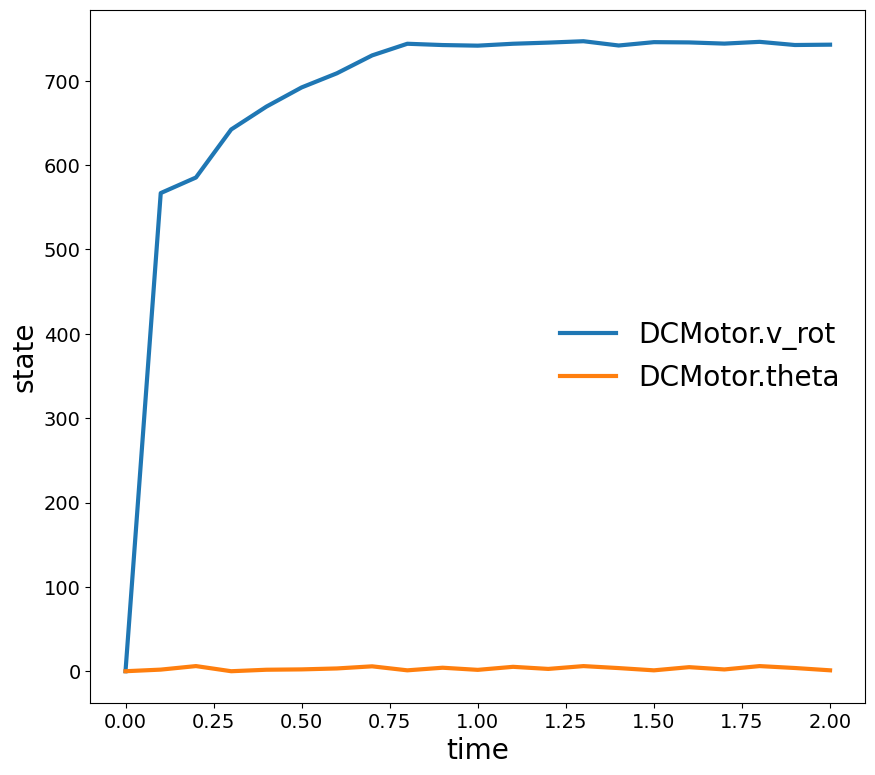

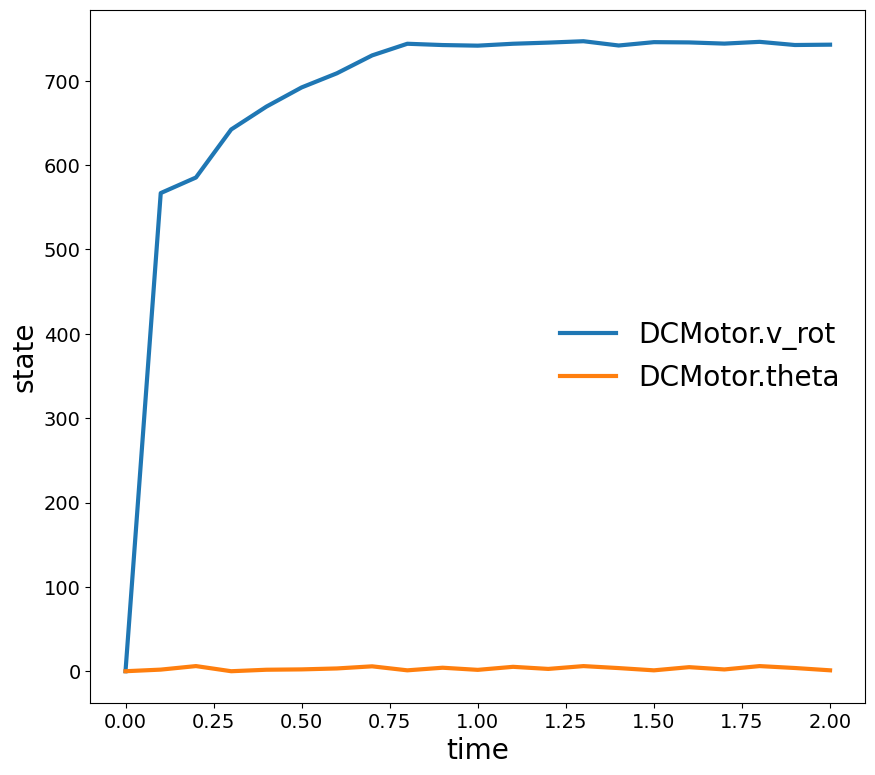

In [7]:
simulated_results.outputs.plot()

It is worth mentioning that the inputs are never changing

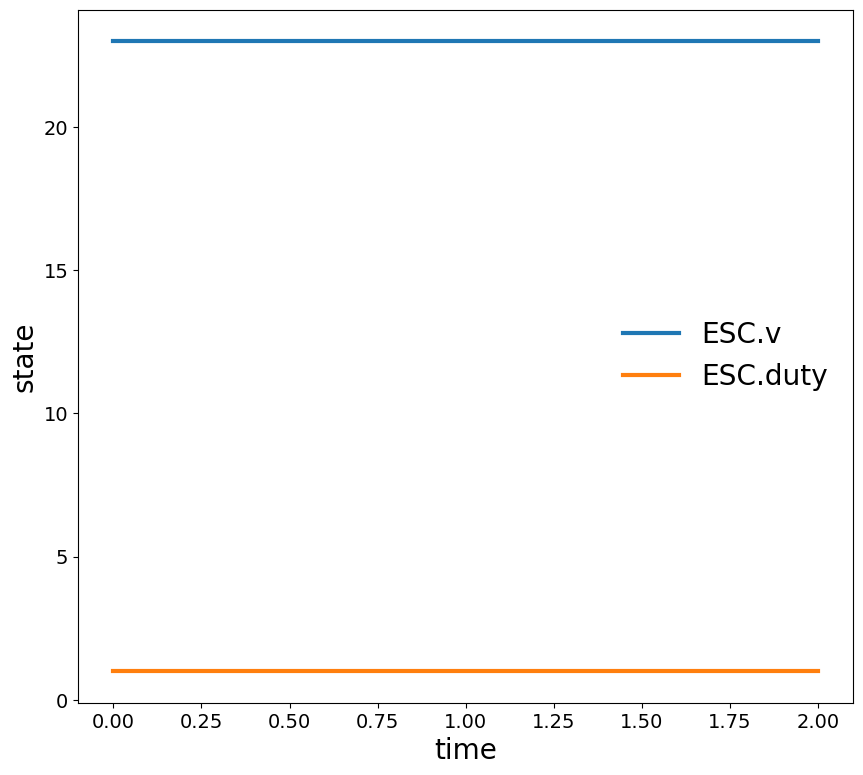

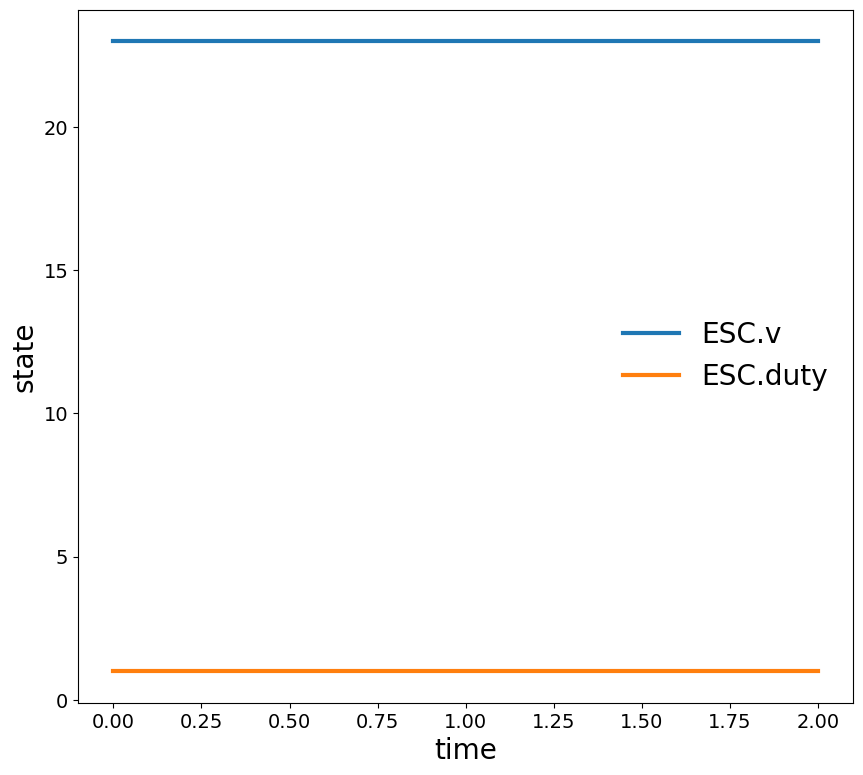

In [8]:
simulated_results.inputs.plot()

Finally, we can view the states of the simulated results to view how the states are changing over time as well!

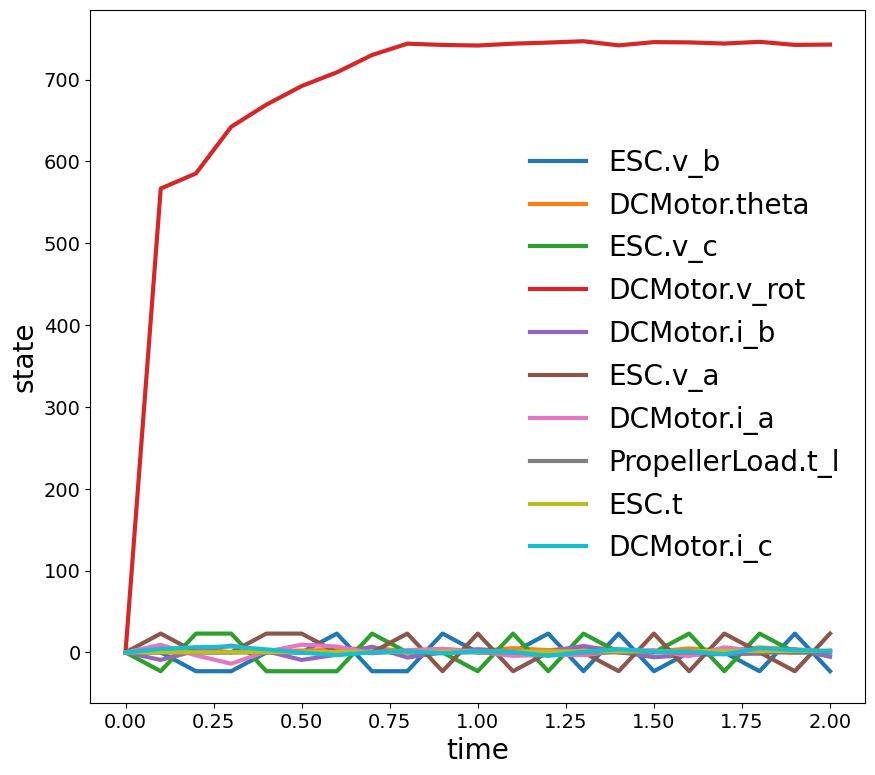

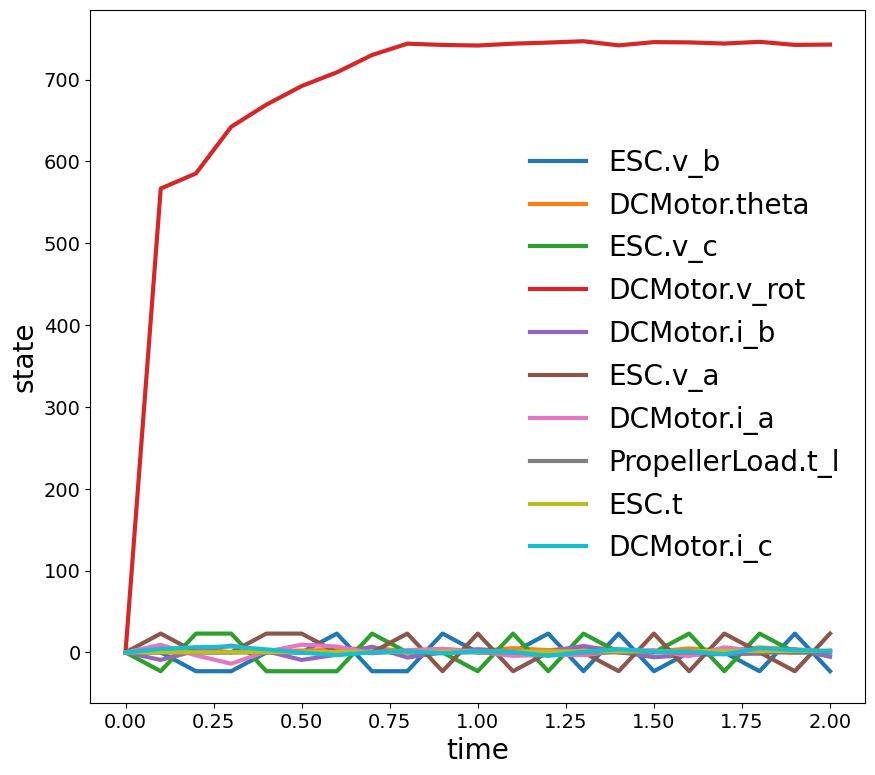

In [9]:
simulated_results.states.plot()

TESTING